In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Bag of Words Meets Bags of Popcorn

# 튜토리얼 파트 2 Word Vectors

* 딥러닝 기법인 Word2Vec을 통해 단어를 벡터화 해본다. 
* t-SNE를 통해 벡터화 한 데이터를 시각화 해본다.
* 딥러닝과 지도학습의 랜덤포레스트를 사용하는 하이브리드 방식을 사용한다.

## Word2Vec(Word Embedding to Vector)

컴퓨터는 숫자만 인식할 수 있고 한글, 이미지는 바이너리 코드로 저장 된다.
튜토리얼 파트1에서는  Bag of Word라는 개념을 사용해서 문자를 벡터화 하여 머신러닝 알고리즘이 이해할 수 있도록 벡터화 해주는 작업을 하였다.


* one hot encoding(예 [0000001000]) 혹은 Bag of Word에서 vector size가 매우 크고 sparse 하므로 neural net 성능이 잘 나오지 않는다.
* `주위 단어가 비슷하면 해당 단어의 의미는 유사하다` 라는 아이디어
* 단어를 트레이닝 시킬 때 주위 단어를 label로 매치하여 최적화
* 단어를 `의미를 내포한 dense vector`로 매칭 시키는 것

* Word2Vec은 분산 된 텍스트 표현을 사용하여 개념 간 유사성을 본다. 예를 들어, 파리와 프랑스가 베를린과 독일이 (수도와 나라) 같은 방식으로 관련되어 있음을 이해한다.

![word2vec](https://1.bp.blogspot.com/-Q7F8ulD6fC0/UgvnVCSGmXI/AAAAAAAAAbg/MCWLTYBufhs/s1600/image00.gif)
이미지 출처 : https://opensource.googleblog.com/2013/08/learning-meaning-behind-words.html

* 단어의 임베딩과정을 실시간으로 시각화 : [word embedding visual inspector](https://ronxin.github.io/wevi/)


![CBOW와 Skip-Gram](https://i.imgur.com/yXY1LxV.png)
출처 : https://arxiv.org/pdf/1301.3781.pdf
 Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013.


* CBOW와 Skip-Gram기법이 있다.

    * CBOW(continuous bag-of-words)는 전체 텍스트로 하나의 단어를 예측하기 때문에 작은 데이터셋일 수록 유리하다.    
    * 아래 예제에서 __ 에 들어갈 단어를 예측한다.
<pre>
1) __가 맛있다. 
2) __를 타는 것이 재미있다. 
3) 평소보다 두 __로 많이 먹어서 __가 아프다.
</pre>

    * Skip-Gram은 타겟 단어들로부터 원본 단어를 역으로 예측하는 것이다. CBOW와는 반대로 컨텍스트-타겟 쌍을 새로운 발견으로 처리하고 큰 규모의 데이터셋을 가질 때 유리하다.
    * `배`라는 단어 주변에 올 수 있는 단어를 예측한다.
    
    <pre>
    1) *배*가 맛있다. 
    2) *배*를 타는 것이 재미있다. 
    3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
    </pre>



## Word2Vec 참고자료

* [word2vec 모델 · 텐서플로우 문서 한글 번역본](https://tensorflowkorea.gitbooks.io/tensorflow-kr/g3doc/tutorials/word2vec/)
* [Word2Vec으로 문장 분류하기 · ratsgo's blog](https://ratsgo.github.io/natural%20language%20processing/2017/03/08/word2vec/)

* [Efficient Estimation of Word Representations in
Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf)
* [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
* [CS224n: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/syllabus.html)
* [Word2Vec Tutorial - The Skip-Gram Model · Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

## Gensim

* [gensim: models.word2vec – Deep learning with word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
* [gensim: Tutorials](https://radimrehurek.com/gensim/tutorial.html)
* [한국어와 NLTK, Gensim의 만남 - PyCon Korea 2015](https://www.lucypark.kr/docs/2015-pyconkr/)




In [4]:
# 출력이 너무 길어지지 않게하기 위해 찍지 않도록 했으나 
# 실제 학습 할 때는 아래 두 줄을 주석처리 하는 것을 권장한다.
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/python git/data/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
test = pd.read_csv('/content/drive/MyDrive/python git/data/testData.tsv', 
                   header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('/content/drive/MyDrive/python git/data/unlabeledTrainData.tsv', 
                              header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [6]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [7]:
# train에 있는 평점정보인 sentiment가 없다.
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [8]:
!wget https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/KaggleWord2VecUtility.py

--2022-10-14 06:49:18--  https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/KaggleWord2VecUtility.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/corazzon/KaggleStruggle/master/word2vec-nlp-tutorial/KaggleWord2VecUtility.py [following]
--2022-10-14 06:49:19--  https://raw.githubusercontent.com/corazzon/KaggleStruggle/master/word2vec-nlp-tutorial/KaggleWord2VecUtility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3250 (3.2K) [text/plain]
Saving to: ‘KaggleWord2VecUtility.py’

KaggleWord2VecUtili 100%[===================>]   3.17K  --.-KB/s    in 0s      

2022-1

In [9]:
# import sys
# sys.path.append('/content/drive/MyDrive/python git/data')
# print(sys.path)

In [10]:
from KaggleWord2VecUtility import KaggleWord2VecUtility

In [11]:
KaggleWord2VecUtility.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
sentences = []
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=False)

In [14]:
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=False)

In [15]:
len(sentences)

794002

In [16]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [17]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

# Word2Vec 모델을 학습
전처리를 거쳐 파싱된 문장의 목록으로 모델을 학습시킬 준비가 되었다.

# Gensim
* gensim: models.word2vec – Deep learning with word2vec

# Word2Vec 모델의 파라메터

* 아키텍처 : 아키텍처 옵션은 skip-gram (default) 또는 CBOW 모델이다. skip-gram (default)은 느리지 만 더 나은 결과를 낸다.

* 학습 알고리즘 : Hierarchical softmax (default) 또는 negative 샘플링. 여기에서는 기본값이 잘 동작한다.

* 빈번하게 등장하는 단어에 대한 다운 샘플링 : Google 문서는 .00001에서 .001 사이의 값을 권장한다. 여기에서는 0.001에 가까운 값이 최종 모델의 정확도를 높이는 것으로 보여진다.

* 단어 벡터 차원 : 많은 feature를 사용한다고 항상 좋은 것은 아니지만 대체적으로 좀 더 나은 모델이 된다. 합리적인 값은 수십에서 수백 개가 될 수 있고 여기에서는 300으로 지정했다.

* 컨텍스트 / 창 크기 : 학습 알고리즘이 고려해야하는 컨텍스트의 단어 수는 얼마나 될까? hierarchical softmax 를 위해 좀 더 큰 수가 좋지만 10 정도가 적당하다.

* Worker threads : 실행할 병렬 프로세스의 수로 컴퓨터마다 다르지만 대부분의 시스템에서 4에서 6 사이의 값을 사용하다.

* 최소 단어 수 : 어휘의 크기를 의미있는 단어로 제한하는 데 도움이 된다. 모든 문서에서이 여러 번 발생하지 않는 단어는 무시된다. 10에서 100 사이가 적당하며, 이 경진대회의 데이터는 각 영화가 30개씩의 리뷰가 있기 때문에 개별 영화 제목에 너무 많은 중요성이 붙는 것을 피하기 위해 최소 단어 수를 40으로 설정한다. 그 결과 전체 어휘 크기는 약 15,000 단어가 된다. 높은 값은 제한 된 실행시간에 도움이 된다.

In [18]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

In [20]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'
model.save(model_name)

# 모델 결과 탐색

In [21]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [22]:
model.wv.doesnt_match("france england germany berlin".split())

'england'

In [23]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

[('woman', 0.6244531869888306),
 ('millionair', 0.5278128385543823),
 ('businessman', 0.5230768918991089),
 ('ladi', 0.5045655965805054),
 ('lad', 0.5031540393829346),
 ('farmer', 0.47139912843704224),
 ('men', 0.4660053253173828),
 ('billionair', 0.45345449447631836),
 ('priest', 0.4513772428035736),
 ('widow', 0.45103955268859863)]

In [24]:
model.wv.most_similar("queen")

[('princess', 0.6147714853286743),
 ('regina', 0.5909870266914368),
 ('victoria', 0.5796344876289368),
 ('mistress', 0.5656699538230896),
 ('angela', 0.5424975156784058),
 ('madam', 0.541057825088501),
 ('goddess', 0.5397129058837891),
 ('maid', 0.5391592979431152),
 ('latifah', 0.5388841032981873),
 ('eva', 0.5383750796318054)]

In [25]:
# model.wv.most_similar("awful")

model.wv.most_similar("film")

[('movi', 0.8564736843109131),
 ('flick', 0.6078011989593506),
 ('documentari', 0.5983785390853882),
 ('pictur', 0.5545501708984375),
 ('cinema', 0.5158914923667908),
 ('masterpiec', 0.5119571685791016),
 ('it', 0.4968760311603546),
 ('genr', 0.4927082061767578),
 ('effort', 0.4880235493183136),
 ('sequel', 0.4847909212112427)]

In [26]:
# model.wv.most_similar("happy")
model.wv.most_similar("happi") # stemming 처리 시 

[('bitter', 0.4491584897041321),
 ('unhappi', 0.4325142800807953),
 ('satisfi', 0.41066086292266846),
 ('happier', 0.403290331363678),
 ('sad', 0.3955286741256714),
 ('upset', 0.3729724884033203),
 ('afraid', 0.3606327772140503),
 ('sadden', 0.36004674434661865),
 ('glad', 0.3567366600036621),
 ('joy', 0.3567126393318176)]

# Word2Vec으로 벡터화 한 단어를 t-SNE 를 통해 시각화

In [27]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

11986
[ 0.05411876  0.02328218  0.0583258  -0.12340507  0.03703851 -0.02718963
 -0.06525541 -0.03436473  0.02135615 -0.05556267]


In [28]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [29]:
df.head(10)

,x,y
with,-5.290315,-4.289643
all,-4.473997,-0.683724
this,-1.392861,0.070400
stuff,-5.974172,0.772282
go,4.578163,-3.244536
down,-3.976852,-8.165124
at,-2.543717,-6.609117
the,-6.007585,-1.595929
moment,-5.047529,5.227607
mj,-8.886503,3.168369


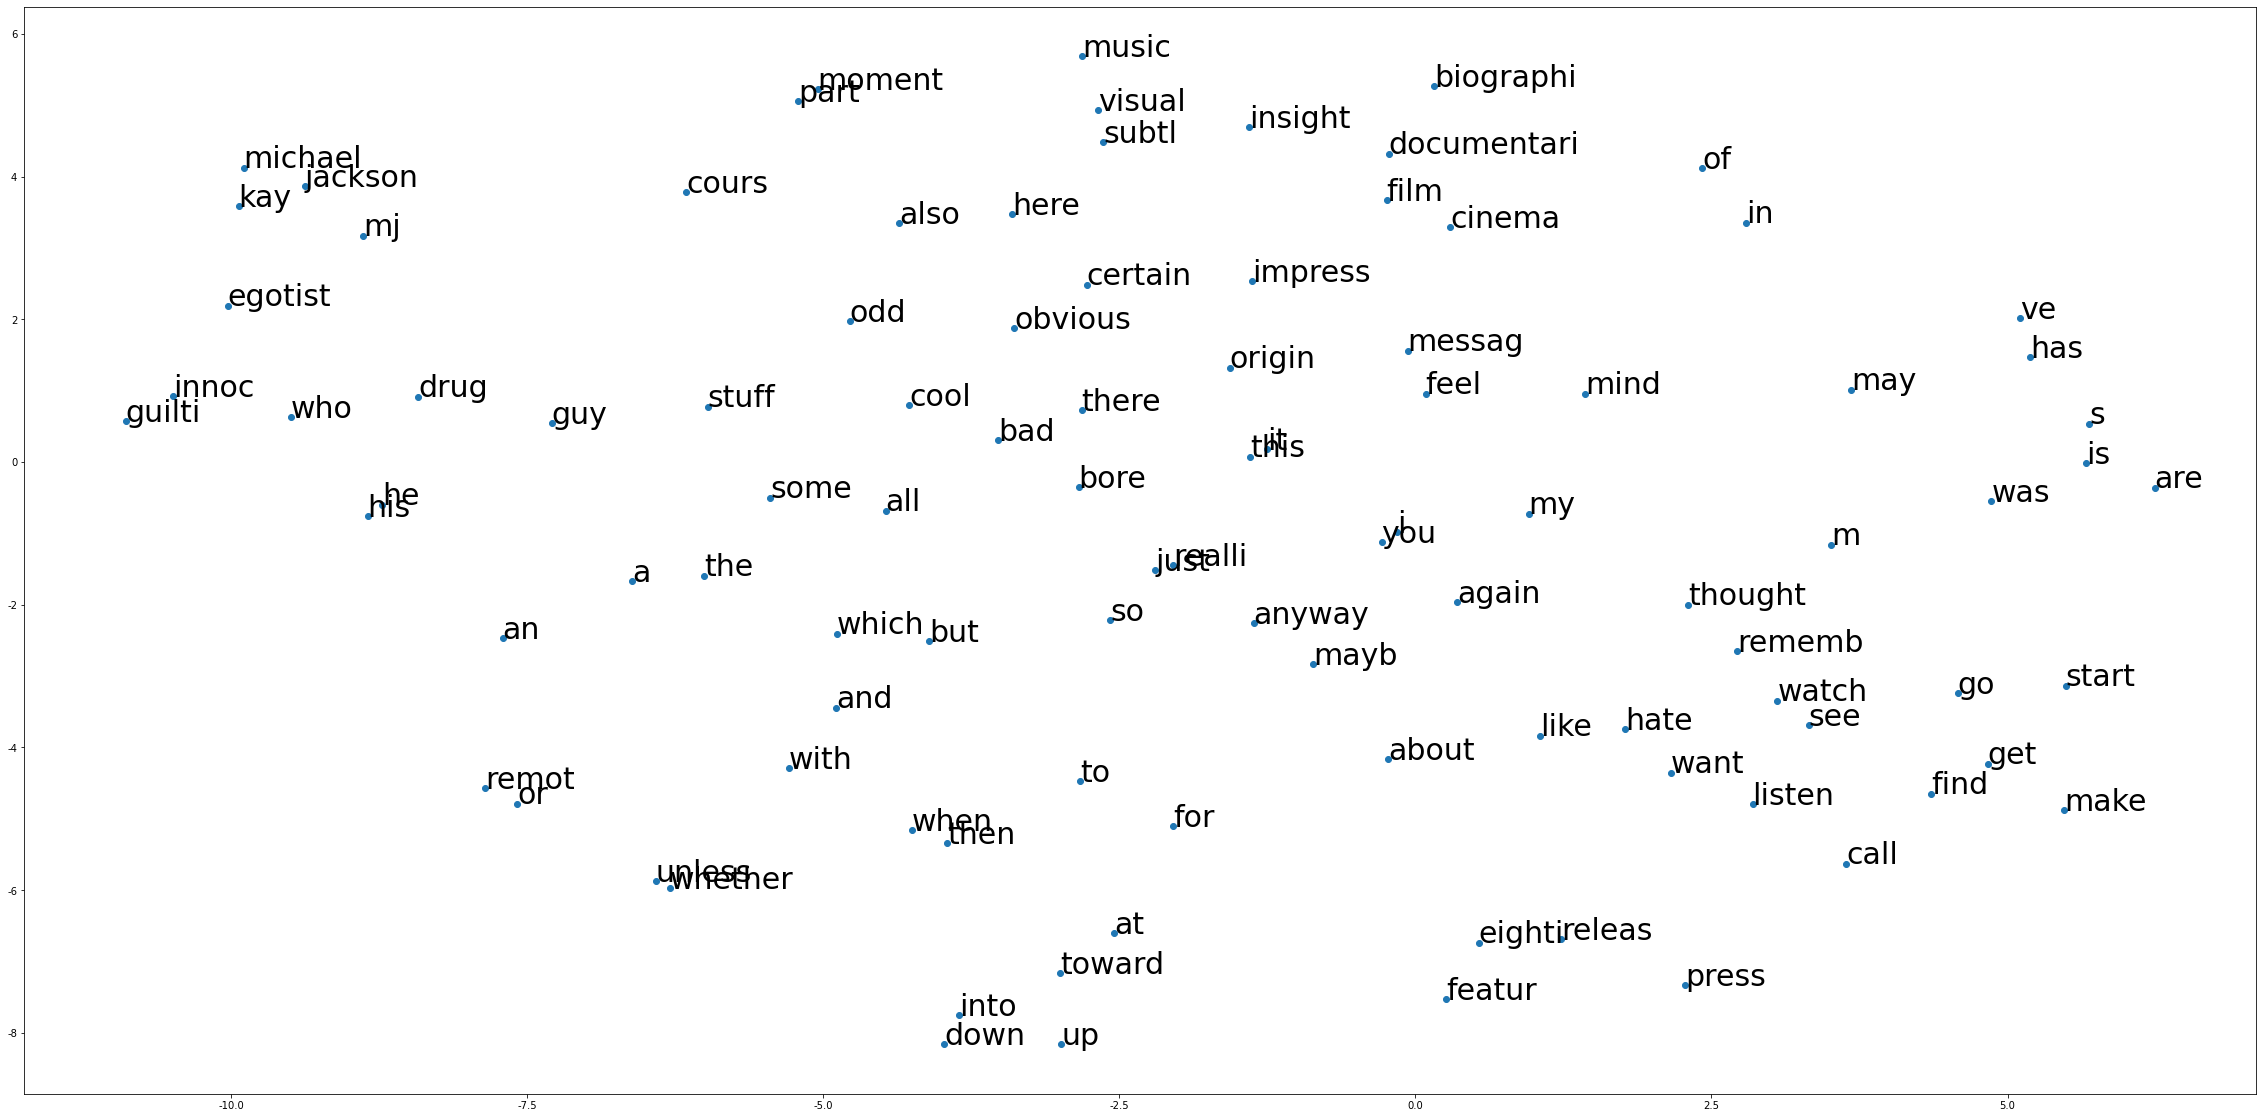

In [30]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [31]:
import numpy as np

def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화 한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.
    # Index2word는 모델의 사전에 있는 단어명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화 한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [32]:
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.
    
    # 카운터를 초기화 한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")
    
    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [33]:
# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(\
        reviews["review"], KaggleWord2VecUtility.review_to_wordlist,\
        workers=4)
    return clean_reviews

In [34]:
%time trainDataVecs = getAvgFeatureVecs(\
    getCleanReviews(train), model, num_features ) 

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 11s, sys: 3.17 s, total: 1min 14s
Wall time: 2min 31s


In [35]:
%time testDataVecs = getAvgFeatureVecs(\
        getCleanReviews(test), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 6s, sys: 3.88 s, total: 1min 10s
Wall time: 2min 28s


In [36]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [37]:
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

CPU times: user 1min 11s, sys: 82.8 ms, total: 1min 11s
Wall time: 36.9 s


In [38]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))

CPU times: user 8.66 s, sys: 1.14 s, total: 9.79 s
Wall time: 5min 37s


In [39]:

score

0.9057803519999998

In [40]:
result = forest.predict( testDataVecs )

In [42]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('/content/drive/MyDrive/python git/data/Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), index=False, quoting=3 )

In [43]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

244


0    12622
1    12378
Name: sentiment, dtype: int64

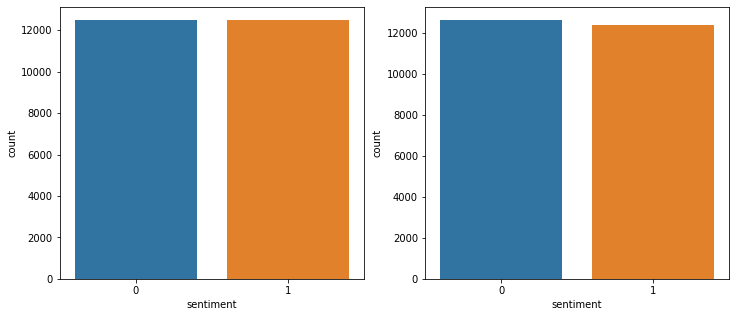

In [44]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

# K-means

# Bag of Words Meets Bags of Popcorn | Kaggle

* DeepLearningMovies/KaggleWord2VecUtility.py at master · wendykan/DeepLearningMovies
* 캐글에 링크 되어 있는 github 튜토리얼을 참고하여 만들었으며 파이썬2로 되어있는 소스를 파이썬3에 맞게 일부 수정하였다.

# 첫 번째 시도(average feature vectors)

* 튜토리얼2의 코드로 벡터의 평균을 구한다.

# 두 번째 시도(K-means)

* Word2Vec은 의미가 관련있는 단어들의 클러스터를 생성하기 때문에 클러스터 내의 단어 유사성을 이용하는 것이다.
* 이런식으로 벡터를 그룹화 하는 것을 "vector quantization(벡터 양자화)"라고 한다.
* 이를 위해서는 K-means와 같은 클러스터링 알고리즘을 사용하여 클러스터라는 단어의 중심을 찾아야 한다.
* 비지도학습인 K-means를 통해 클러스터링을 하고 지도학습인 랜덤포레스트로 리뷰가 추천인지 아닌지를 예측한다.

In [45]:
!pip install BeautifulSoup4
!pip install gensim
!pip install -U nltk
# !pip install --upgrade gensim==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from bs4 import BeautifulSoup
import re
import time

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
model = Word2Vec.load('300features_40minwords_10text')
model

In [48]:
# 숫자로 단어를 표현
# Word2Vec 모델은 어휘의 각 단어에 대한 feature 벡터로 구성되며 
# 'syn0'이라는 넘파이 배열로 저장된다.
# syn0의 행 수는 모델 어휘의 단어 수
# 컬럼 수는 2 부에서 설정 한 피처 벡터의 크기
type(model.wv.syn0)

numpy.ndarray

In [50]:
# syn0의 행 수는 모델 어휘의 단어 수
# 열 수는 2부에서 설정한 특징 벡터의 크기
model.wv.syn0.shape

(11986, 300)

In [51]:
# 개별 단어 벡터 접근
model.wv['flower'].shape

(300,)

In [52]:
model.wv['flower'][:10]

array([ 0.07395413, -0.00300969, -0.02500876, -0.0236865 ,  0.06361946,
       -0.06254984,  0.03965311, -0.05989024, -0.04074845, -0.06985677],
      dtype=float32)

# K-means (K평균)클러스터링으로 데이터 묶기

* [K-평균 알고리즘 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/K-%ED%8F%89%EA%B7%A0_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98)

* 클러스터링은 비지도 학습 기법

클러스터링은 유사성 등 개념에 기초해 몇몇 그룹으로 분류하는 기법
클러스터링의 목적은 샘플(실수로 구성된 n차원의 벡터)을 내부적으로는 비슷하지만 외부적으로 공통 분모가 없는 여러 그룹으로 묶는 것
특정 차원의 범위가 다른 차원과 차이가 크면 클러스터링 하기 전에 스케일을 조정해야 한다.

1. 최초 센트로이드(centroid)(중심점)로 k개의 벡터를 무작위로 선정한다.
2. 각 샘플을 그 위치에서 가장 가까운 센트로이드에 할당한다.
3. 센트로이드의 위치를 재계산한다.
4. 센트로이드가 더 이상 움직이지 않을 때까지 2와 3을 반복한다.

참고 : [책] 모두의 데이터 과학(with 파이썬)

In [49]:
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5 이나 평균 5단어로 설정한다.
word_vectors = model.wv.syn0 # 어휘의 feature vector
num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)
num_clusters

2397

In [53]:
# K means 를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난시간에서 시작시간을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  786.579509973526 seconds.


In [54]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

# 첫번째 클러스터의 처음 10개를 출력
for cluster in range(0,10):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))
    
    # 클러스터번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['healthi']

Cluster 1
['stephen', 'rudolf', 'luther']

Cluster 2
['pervers', 'degrad', 'cruelti', 'arous', 'deprav', 'pornographi', 'sordid', 'hysteria', 'deviant', 'sadism', 'lunaci', 'voyeurist', 'bestial', 'reprehens', 'carnal', 'sensate', 'patholog', 'abject']

Cluster 3
['keeper', 'scoop', 'cotton', 'thorn', 'moonlight', 'burrow', 'belat', 'fluke', 'pike', 'snag']

Cluster 4
['town', 'villag', 'monasteri']

Cluster 5
['canva', 'vista', 'postcard']

Cluster 6
['electron', 'drone', 'synthes', 'keyboard', 'stereo']

Cluster 7
['flood', 'submerg', 'populac', 'erad']

Cluster 8
['farrah', 'fawcett']

Cluster 9
['strengthen']


In [57]:
"""
판다스로 데이터프레임 형태의 데이터로 읽어온다.
QUOTE_MINIMAL (0), QUOTE_ALL (1), 
QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

그리고 이전 튜토리얼에서 했던 것처럼 clean_train_reviews 와 
clean_test_reviews 로 텍스트를 정제한다.
"""
train = pd.read_csv('/content/drive/MyDrive/python git/data/labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)
test = pd.read_csv('/content/drive/MyDrive/python git/data/testData.tsv', header=0, delimiter="\t", quoting=3)
# unlabeled_train = pd.read_csv( 'data/unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3 )

In [67]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [68]:
from KaggleWord2VecUtility import KaggleWord2VecUtility
# 학습 리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [69]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [70]:
# bags of centroids 생성
# 속도를 위해 centroid 학습 세트 bag을 미리 할당 한다.
train_centroids = np.zeros((train["review"].size, num_clusters), \
    dtype="float32" )
print(train_centroids.shape)
train_centroids[:5]

(25000, 2397)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [71]:
# centroid 는 두 클러스터의 중심점을 정의 한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids( wordlist, word_centroid_map ):
    
    # 클러스터의 수는 word / centroid map에서 가장 높은 클러스트 인덱스와 같다.
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당되는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # bag of centroids를 반환한다.
    return bag_of_centroids

In [72]:
# 학습 리뷰를 bags of centroids 로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    counter += 1


# 랜덤포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators = 100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time을 통해 걸린 시간을 찍도록 함
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])

Fitting a random forest to labeled training data...
CPU times: user 41.8 s, sys: 170 ms, total: 42 s
Wall time: 41.8 s


In [73]:
temp = pd.DataFrame(test_centroids)
print(temp.shape)
temp.sum()

(25000, 2397)


0         67.0
1        327.0
2        675.0
3        234.0
4       1631.0
         ...  
2392      10.0
2393      12.0
2394      38.0
2395      26.0
2396    1267.0
Length: 2397, dtype: float32

In [74]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_centroids, train['sentiment'], cv=10,\
    scoring='roc_auc'))

CPU times: user 4min 30s, sys: 575 ms, total: 4min 31s
Wall time: 4min 30s


In [75]:
%time result = forest.predict(test_centroids)

CPU times: user 2.07 s, sys: 5.65 ms, total: 2.08 s
Wall time: 2.07 s


In [76]:
score

0.9133383040000002

In [77]:
# 결과를 csv로 저장
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("/content/drive/MyDrive/python git/data/submit_BagOfCentroids_{0:.5f}.csv".format(score), index=False, quoting=3)

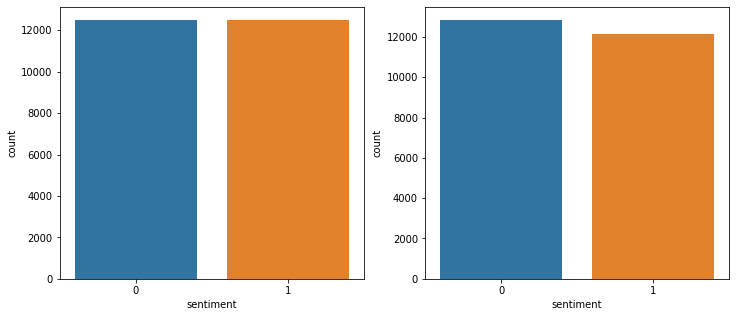

In [78]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [79]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

678


0    12839
1    12161
Name: sentiment, dtype: int64

왜 이 튜토리얼에서는 Bag of Words가 더 좋은 결과를 가져올까?
벡터를 평균화하고 centroids를 사용하면 단어 순서가 어긋나며 Bag of Words 개념과 매우 비슷하다. 성능이 (표준 오차의 범위 내에서) 비슷하기 때문에 튜토리얼 1, 2, 3이 동등한 결과를 가져온다.

첫째, Word2Vec을 더 많은 텍스트로 학습시키면 성능이 좋아진다. Google의 결과는 10 억 단어가 넘는 코퍼스에서 배운 단어 벡터를 기반으로 한다. 학습 레이블이 있거나 레이블이 없는 학습 세트는 단지 대략 천팔백만 단어 정도다. 편의상 Word2Vec은 Google의 원래 C도구에서 출력되는 사전 학습 된 모델을 로드하는 기능을 제공하기 때문에 C로 모델을 학습 한 다음 Python으로 가져올 수도 있다.

둘째, 출판 된 자료들에서 분산 워드 벡터 기술은 Bag of Words 모델보다 우수한 것으로 나타났다. 이 논문에서는 IMDB 데이터 집합에 단락 벡터 (Paragraph Vector)라는 알고리즘을 사용하여 현재까지의 최첨단 결과 중 일부를 생성한다. 단락 벡터는 단어 순서 정보를 보존하는 반면 벡터 평균화 및 클러스터링은 단어 순서를 잃어 버리기 때문에 여기에서 시도하는 방식보다 부분적으로 더 좋다.